In [3]:
# import statements
import math
from autograd import numpy as np
import scipy as scp
from autograd import grad 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func
from autograd import value_and_grad 
from matplotlib import gridspec
from matplotlib import cm
%matplotlib inline

In [4]:
def deltafxn(x,y):
    if x == y:
        return 1
    else:
        return 0

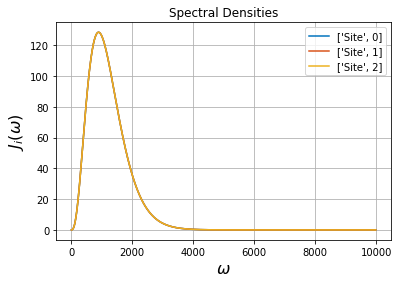

In [5]:

pltc =          np.array([[0 ,   0.4470 ,   0.7410],
    [0.8500 ,   0.3250  ,  0.0980],
    [0.9290 ,   0.6940  ,  0.1250],
    [0.4940   , 0.1840  ,  0.5560],
    [0.4660  ,  0.6740 ,   0.1880],
    [0.3010  ,  0.7450 ,   0.9330],
    [0.6350   , 0.0780  ,  0.1840]]);

pi = math.pi

c = 3e-5

Nw = int(1e3)
domega = 10
omega = np.arange(domega,(Nw)*domega,domega)

Nt = int(512)
dt_fs = 1
dt = 2*pi*dt_fs*c
t = np.arange(0,(Nt)*dt,dt)
t = t.T

omega_c = 300;
gamma_i = 1; 
theta = omega_c;

J0 = 0.5*omega_c;
Delta = 0.5*omega_c;

H_S = np.array([[-Delta, J0/2, J0], [J0/2, 0, J0/2],[J0,J0/2,Delta]]);
M = len(H_S)
[E,V_S] = np.linalg.eigh(H_S); 
omega_c = np.tile(omega_c,M)
gamma_i = np.tile(gamma_i,M)
#omega_c = np.array([300, 500, 800])
#gamma_i = np.array([0.3, 0.2, 0.3])

JJ = []
for i in range(M):
    A = gamma_i[i]*omega**3*np.exp(-omega/omega_c[i])/(pi*omega_c[i]**2)
    JJ.append(A)

for i in range(M):
    plt.plot(omega,JJ[i],color=pltc[i,:],label=['Site', i]);
plt.grid(True)
plt.legend(loc=1)
plt.xlabel(r'$\omega$',Fontsize=16)
plt.ylabel(r'$J_i(\omega)$',Fontsize=16)
plt.title('Spectral Densities')
plt.show()


Y = np.zeros(shape=(M,M,Nw,Nt),dtype=complex);
Q = np.zeros(shape=(M,M,M,M,Nt),dtype=complex);
Rtot = np.zeros(shape=(M,M,M,M),dtype=complex);

for i in range(M):
    for j in range(M):
        for k in range(Nw-1):
            J = JJ[i]
            Y[i,j,k,:] = deltafxn(i,j)*( J[k]*(np.cos(omega[k]*t)*(np.tanh(omega[k]/2/theta))**(-1) - 1j*np.sin(omega[k]*t)) );
            
for alpha in range(M):
    for beta in range(M):
        for gamma in range(M):
            for delta in range(M):
                Temp = 0
                for n in range(M):
                    for m in range(M):
                        A = np.squeeze(np.sum(Y[n,m,:,:],0))
                        Temp  = Temp + np.conj(V_S[n,alpha])*V_S[n,beta]*np.conj(V_S[m,gamma])*V_S[m,delta]*A*domega;
                Q[alpha,beta,gamma,delta,:] = Temp;
                
for alpha in range(M):
    for beta in range(M):
        for gamma in range(M):
            for delta in range(M):
                
                R1temp = 0
                for eta in range(M):
                    R1temp = R1temp + np.sum(np.exp(-1j*(E[eta] - E[gamma])*t)*np.squeeze(Q[gamma,eta,eta,alpha,:]));
                R1v = deltafxn(beta,delta)*R1temp; 
                
                R2v = np.sum(np.exp(-1j*(E[delta] - E[beta])*t)*np.squeeze(np.conj(Q[delta,beta,gamma,alpha,:])));
                
                R3v = np.sum(np.exp(-1j*(E[alpha] - E[gamma])*t)*np.squeeze(Q[gamma,alpha,delta,beta,:]));

                R4temp = 0;
                for eta in range(M):
                    R4temp = R4temp + np.sum(np.exp(-1j*(E[delta] - E[eta])*t)*np.squeeze(np.conj(Q[delta,eta,eta,beta,:])));
                R4v = deltafxn(gamma,alpha)*R4temp; 
                
                Rtot[alpha,beta,gamma,delta] = -1j*(E[gamma] - E[delta])*deltafxn(alpha,gamma)*deltafxn(delta,beta) - (R1v - R2v - R3v + R4v)*dt;
              
                

In [6]:
rho0_site = np.zeros(shape=(M,M),dtype=float);
rho0_site[0,0] = 0; rho0_site[0,1] = 0; rho0_site[1,0] = 0; rho0_site[1,1] = 0.8;
rho0_site[2,2] = 0.2; 

rho0 = V_S.T@rho0_site@V_S; 
R_rs = np.reshape(Rtot,(M**2,M**2))

Nteval = Nt
dteval = dt
teval = np.linspace(0,Nteval*dteval,Nteval)
tplot = teval*omega_c[0]
taus = teval/(2*pi*c); 

rho_site = np.zeros(shape=(M,M,Nteval),dtype=complex); 
rhoM = np.zeros(shape=(M**2,Nteval),dtype=complex);  

x0 = np.reshape(rho0,(M**2,1))
rho_site[:,:,0] = rho0_site
rhoM[:,0] = x0.T

for i in range(1,Nteval):
    
    # Forward Euler
    #x0 = x0 + dteval*R_rs@x0
    
    #m1 = squeeze(L(teval(i)));
    #m2 = squeeze(L(teval(i)+0.5*dteval));
    #m3 = squeeze(L(teval(i)+0.5*dteval));
    #m4 = squeeze(L(teval(i)+dteval));
        
    # Fourth-order Runge-Kutta (RK4)
    k1 = dteval*R_rs@x0;
    k2 = dteval*R_rs@(x0+0.5*k1);
    k3 = dteval*R_rs@(x0+0.5*k2);
    k4 = dteval*R_rs@(x0+k3);
        
    x0 = x0 + 1/6*(k1 + 2*k2 + 2*k3 + k4);
        
    #rhoM.append(x0);
    #rho_site.append(V_S*np.reshape(rhoM[i],(M,M))*V_S.T);
    rhoM[:,i] = x0.T
    rho_site[:,:,i] = V_S@np.reshape(rhoM[:,i],(M,M))@V_S.T


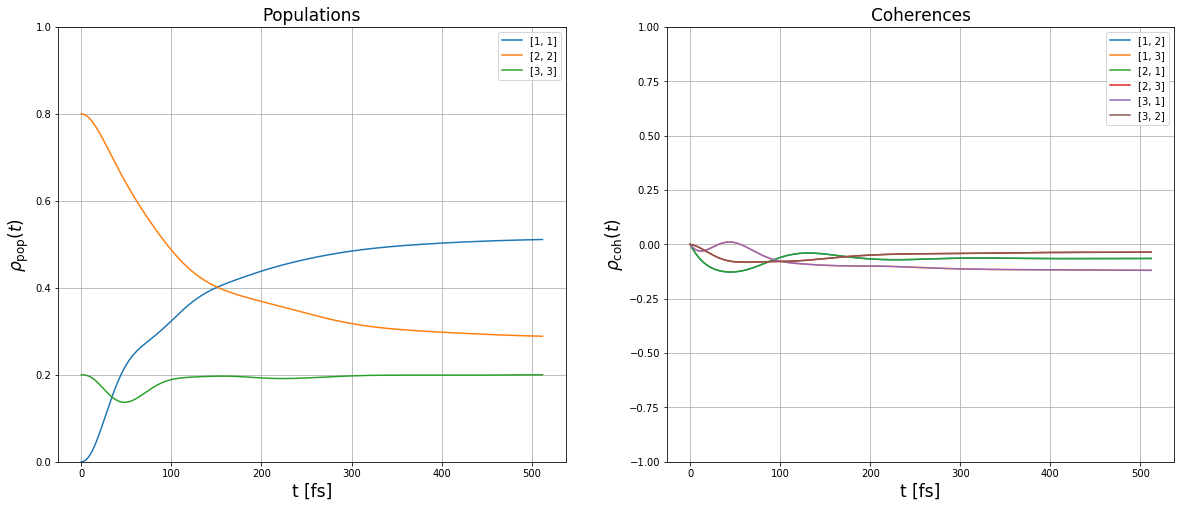

In [7]:
fig = plt.figure(figsize = (20,8))

gs = gridspec.GridSpec(1,2) 
ax1 = plt.subplot(gs[0]); 
ax2 = plt.subplot(gs[1]); 

for i in range(M):
    for j in range(M):
        if i == j:
            ax1.plot(taus,np.real(np.squeeze(rho_site[i,i,:])),label=[i+1, i+1])
        else:
            ax2.plot(taus,np.real(np.squeeze(rho_site[i,j,:])),label=[i+1, j+1])
ax1.grid(True)
ax1.set_xlabel('t [fs]',Fontsize=17)
ax1.set_ylabel(r'$\rho_{\mathrm{pop}}(t)$',Fontsize=17)
ax1.legend(loc=1)
ax1.set_ylim(0,1)
ax1.set_title('Populations',Fontsize=17)

ax2.grid(True)
ax2.set_xlabel('t [fs]',Fontsize=17)
ax2.set_ylabel(r'$\rho_{\mathrm{coh}}(t)$',Fontsize=17)
ax2.legend(loc=1)
ax2.set_ylim(-1,1)
ax2.set_title('Coherences',Fontsize=17);